# Asset Allocation Model

pg. 161 from "Trading Evolved" by Andreas F. Clenow

"The rules of this first ETF model are the following.  We will use five ETFs to allocate our assets to.  Each ETF will have a target weight, and at the beginning of each month we will reset the allocation to this target weight."

25%  SPY - S&P500 Index Tracker ETF
30%  TLT - 20 Year Treasury ETF
30%  IEF - 7-10 Year Treasury ETF
7.5% GLD - Gold Tracker ETF
7.5% DBC - General Commodity Tracker ETF

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from talib.abstract import *
#import numpy as np

import pinkfish as pf

# format price data
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [2]:
# set size of inline plots
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

Portfolios

In [3]:
# large diversified ETFs
large_diversified_weights = {
    
    # stocks:US
    'SPY': 0.20, #1993
    'QQQ': 0.10, #1999
    # stocks:global
    'EFA': 0.05, #2001
    # stocks:emerging markets
    'EEM': 0.05, #2003
    # 40% stocks
    
    # bonds:treasuries
    'TLT': 0.05, #2002
    'IEF': 0.05, #2002
    'TIP': 0.05, #2003
    'BSV': 0.05, #2007
    # bonds:corporate bonds
    'LQD': 0.05, #2002
    # bonds: fixed income
    'AGG': 0.05, #2003
    # 30% bonds
    
    # metals
    'GLD': 0.10, #2004
    'SLV': 0.05, #2006
    # 15% metals
    
    # commodities 5%
    'DBC': 0.05, #2006
    
    # real estate 10%
    'NLY': 0.10  #1997 
}

# pinkfish portfolio
pinkfish_weights = \
    {'SPY': 0.20, 'QQQ':0.20, 'TLT': 0.20, 'NLY': 0.20, 'GLD': 0.20}

# 50% S&P 500, 50% treasury
fifty_fifty_weights = \
    {'SPY': 0.50, 'TLT': 0.50}

# ETF portfolio in "Trading Evolved"
trading_evolved_weights = \
    {'SPY': 0.25, 'TLT': 0.30, 'IEF': 0.30, 'GLD': 0.075, 'DBC': 0.075}

# Dave Ramsey - 25% Growth and income, 25% Growth, 25% Aggressive growth, 25% International
dave_ramsey_weights = \
    {'SPY': 0.25, 'VQNPX': 0.25, 'RPG': 0.25, 'EFA': 0.25}

# Warren Buffett Retirement Fund: 90% S&P500, 10% Short Term Treasuries
warren_buffett_weights = \
    {'SPY': 0.90, 'SHY': 0.10}

# https://www.forbes.com/sites/baldwin/2016/07/25/eight-famous-portfolios/#42c50d7d5cce
# american households: 25% real estate, 30% stocks, 30% fixed income, 5% cash, 10% alternatives
american_households_weights = \
    {'NLY': 0.25, 'SPY': 0.30, 'AGG': 0.30, 'GLD': 0.10}

# janet yellen: 50% fixed income, 40% S&P500, 10% cash
janet_yellen_weights = \
    {'AGG': 0.50, 'SPY': 0.40}

# janet yellen: 50% fixed income, 40% S&P500, 10% gold
janet_yellen_plus_weights = \
    {'AGG': 0.50, 'SPY': 0.40, 'GLD': 0.10}

Some global data

In [4]:
#select one of the above
weights = fifty_fifty_weights

symbols = list(weights.keys())
capital = 10000
margin = pf.Margin.CASH
start = datetime.datetime(1900, 1, 1)
end = datetime.datetime.now()

use_cache = True

In [5]:
# fetch timeseries
portfolio = pf.Portfolio()
ts = portfolio.fetch_timeseries(symbols, start, end, use_cache=use_cache)
ts

,SPY_high,SPY_low,SPY_close,TLT_high,TLT_low,TLT_close
date,,,,,,
1993-01-29,26.20,26.07,26.18,nan,nan,nan
1993-02-01,26.37,26.20,26.37,nan,nan,nan
1993-02-02,26.44,26.30,26.43,nan,nan,nan
1993-02-03,26.72,26.44,26.71,nan,nan,nan
1993-02-04,26.87,26.50,26.82,nan,nan,nan
...,...,...,...,...,...,...
2020-07-21,326.93,323.94,325.01,167.72,167.08,167.29
2020-07-22,327.20,324.50,326.86,168.46,167.69,167.79
2020-07-23,327.23,321.48,322.96,169.88,168.48,169.75


In [6]:
# add calendar columns
ts = portfolio.calendar(ts)

In [7]:
ts, start = portfolio.finalize_timeseries(ts, start)

In [8]:
portfolio.init_trade_logs(ts, capital, margin)
pf.TradeLog.instance

{'SPY': <pinkfish.trade.TradeLog at 0x7f03911d6be0>,
 'TLT': <pinkfish.trade.TradeLog at 0x7f03911d6910>}

In [9]:
# trading algorithm
for i, row in enumerate(ts.itertuples()):

    date = row.Index.to_pydatetime()
    end_flag = pf.is_last_row(ts, i)

    # rebalance on the first trading day of each month
    if row.first_dotm or end_flag:
        #portfolio.print_holdings(date, row)
        #TODO: use share_percent() and adjust positions that need reducing first
        for symbol in portfolio.symbols:
            #print(symbol, portfolio.share_percent(row, symbol))
            price = portfolio.get_row_column_value(row, symbol)
            weight = 0 if end_flag else weights[symbol]
            portfolio.adjust_percent(date, price, weight, symbol, row)
    # record daily balance
    portfolio.record_daily_balance(date, row)

In [10]:
# get logs
rlog, tlog, dbal = portfolio.get_logs()

In [11]:
rlog.head()

,date,seq_num,price,shares,entry_exit,direction,symbol
0,2002-08-01,0,62.22,80,entry,LONG,SPY
1,2002-08-01,1,43.92,113,entry,LONG,TLT
2,2002-09-03,2,46.78,3,exit,LONG,TLT
3,2002-10-01,3,60.34,3,entry,LONG,SPY
4,2002-10-01,4,47.44,3,exit,LONG,TLT


In [12]:
tlog.tail()

,entry_date,entry_price,exit_date,exit_price,pl_points,pl_cash,qty,cumul_total,direction,symbol
309,2020-04-01,245.07,2020-07-24,320.88,75.81,379.04,5,39038.30,LONG,SPY
310,2020-05-01,281.55,2020-07-24,320.88,39.33,235.97,6,39274.27,LONG,SPY
311,2020-05-01,167.54,2020-07-24,169.74,2.20,15.41,7,39289.69,LONG,TLT
312,2020-06-01,162.09,2020-07-24,169.74,7.65,61.20,8,39350.89,LONG,TLT
313,2020-07-01,163.42,2020-07-24,169.74,6.32,6.32,1,39357.21,LONG,TLT


In [13]:
dbal.head()

,high,low,close,shares,cash,leverage,state
date,,,,,,,
2002-07-30,10000.00,10000.00,10000.00,0,10000.00,1.00,-
2002-07-31,10000.00,10000.00,10000.00,0,10000.00,1.00,-
2002-08-01,10000.00,10000.00,10000.00,193,59.96,1.00,O
2002-08-02,9939.25,9939.25,9939.25,193,59.96,1.00,-
2002-08-05,9792.06,9792.06,9792.06,193,59.96,1.00,-


In [14]:
stats = pf.stats(ts, tlog, dbal, capital)
pf.print_full(stats)

start                                                    2002-07-30
end                                                      2020-07-24
beginning_balance                                             10000
ending_balance                                             49357.21
total_net_profit                                           39357.21
gross_profit                                               39357.21
gross_loss                                                     0.00
profit_factor                                                  1000
return_on_initial_capital                                    393.57
annual_return_rate                                             9.28
trading_period                           17 years 11 months 24 days
pct_time_in_market                                            99.96
margin                                                            1
avg_leverage                                                   1.00
max_leverage                                    

,cumul_total,weight,pct_cumul_total,relative_performance
SPY,"$21,412.03",0.50,0.54,1.09
TLT,"$17,945.18",0.50,0.46,0.91
TOTAL,"$39,357.21",1.00,1.00,1.00


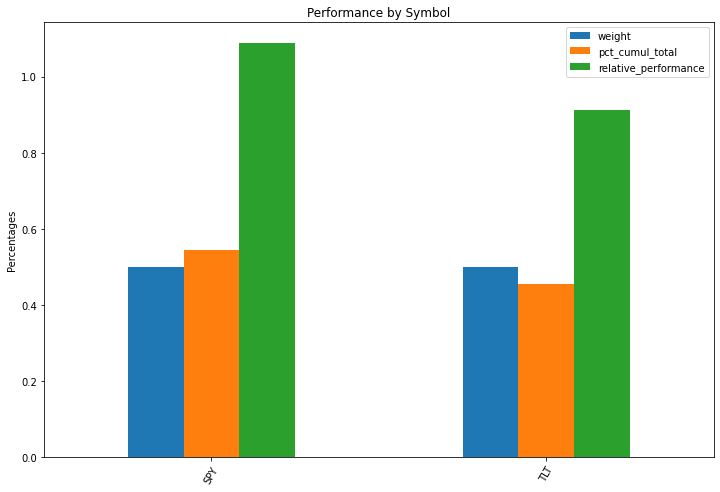

In [15]:
totals = portfolio.performance_per_symbol(weights)
totals

,SPY,TLT
SPY,1.00,0.89
TLT,0.89,1.00


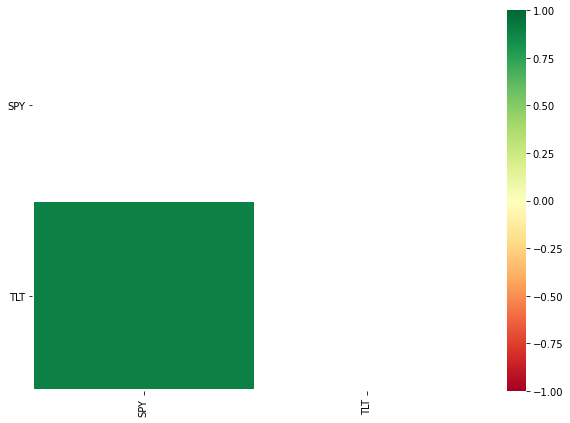

In [16]:
corr_df = portfolio.correlation_map(ts)
corr_df

In [17]:
benchmark = pf.Benchmark('SPY', capital, start, end, use_adj=True)
benchmark.run()

2002-07-30 00:00:00 BUY  156 SPY @ 63.73
2020-07-27 00:00:00 SELL 156 SPY @ 323.22


In [18]:
benchmark.tlog, benchmark.dbal = benchmark.get_logs()

In [19]:
benchmark.stats = benchmark.get_stats()

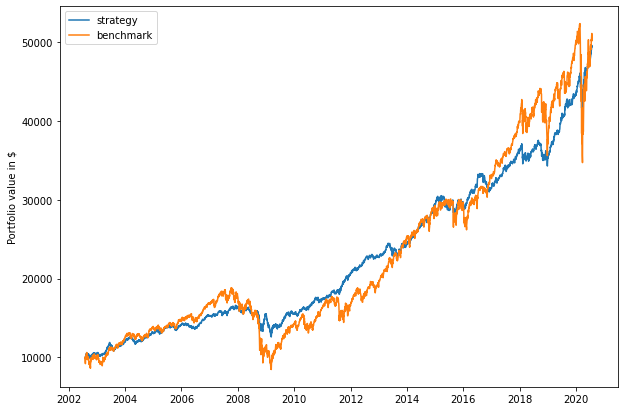

In [20]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal)

In [21]:
df = pf.summary(stats, benchmark.stats, metrics=pf.currency_metrics)
df

,strategy,benchmark
beginning_balance,"$10,000.00","$10,000.00"
ending_balance,"$49,357.21","$50,480.17"
total_net_profit,"$39,357.21","$40,480.17"
gross_profit,"$39,357.21","$40,480.17"
gross_loss,$0.00,$0.00


,strategy,benchmark
annual_return_rate,9.28,9.41
max_closed_out_drawdown,-24.08,-55.02
drawdown_annualized_return,-2.59,-5.84
drawdown_recovery,-1.26,-1.42
best_month,17.21,23.46
worst_month,-14.86,-30.95
sharpe_ratio,1.05,0.56
sortino_ratio,1.40,0.68
monthly_std,2.41,4.52


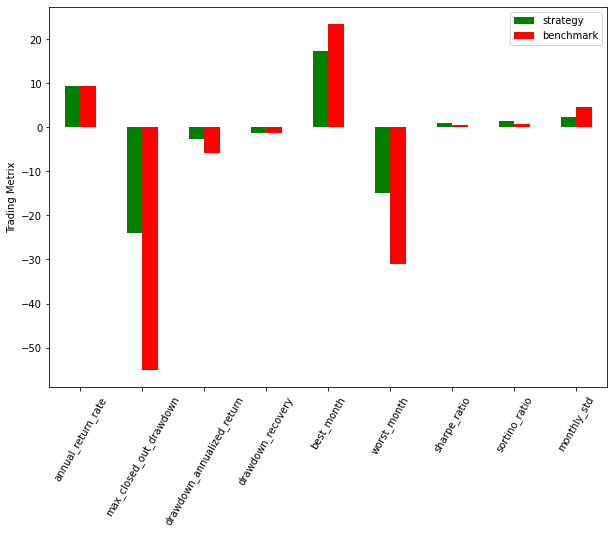

In [22]:
df = pf.plot_bar_graph(stats, benchmark.stats)
df